# *S. cerevisiae* pathway occupancy, Extended Data Fig 8 b and e

In [1]:
#import packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
import scipy as scipy
import math 
from tqdm.auto import tqdm
import re

In [2]:
# don't print warning messages
import warnings
warnings.filterwarnings('ignore')

### Inital data wranggling

In [3]:
#read in proteomics datasets 
yeast_proteomics = pd.read_csv('./data/2024_01_05_yeast_proteomics_full.csv')

#read in gene inclusion list for fermentation and respiration
yeast_inclusion = pd.read_csv('./data/yeast_inclusion.csv')
yeast_inclusion = yeast_inclusion[['EC number', 'pathway', 'Gene name', 'meta_pathway', 'ORF', 'MW']].drop_duplicates()

#read in proteomics datasets 
yeast_meta = pd.read_csv('./data/2024_01_05_yeast_metadata.csv')
yeast_meta.rename(columns = {'column_title':'variable'}, inplace = True)

In [4]:
#adding membrance protein category
ec_numbers = [
    'glucose transport', 
    'pyruvate transport', 
    'phosphate carrier protein', 
    'etc', 
    'ATP/ADP carrier protein', 
    'mito_shuttle']

yeast_inclusion.loc[yeast_inclusion['EC number'].isin(ec_numbers), 'protein category'] = 'membrane'

In [5]:
#creating column list from column names without ORF
column_list = np.array([col for col in yeast_proteomics.columns if col != 'ORF'])

#reshaping df with melt
yeast_proteomics_melt = pd.melt(yeast_proteomics, id_vars=['ORF'],
                                 value_vars=column_list)

In [6]:
#merging with meta data
yeast_proteomics_melt = pd.merge(yeast_proteomics_melt, yeast_meta, on='variable', how='left')

#subsetting df
yeast_inclusion = yeast_inclusion[['Gene name', 'pathway', 'ORF', 'meta_pathway', 'protein category', 'EC number', 'MW']]

#merging with inclusion list
total_inclusion = pd.merge(yeast_inclusion, yeast_proteomics_melt, on='ORF', how='left')

In [7]:
#drop datases that are not mass spec or do not meet the extraction criteria 
total_inclusion = total_inclusion.loc[total_inclusion['quant'] == 'mass_spec']

total_inclusion = total_inclusion.loc[~(total_inclusion['author'].str.contains('Lu'))]

### ETC Correction

In [8]:
#subsetting the etc inclusion list
total_inclusion_etc = total_inclusion.loc[((total_inclusion['pathway'].str.contains('etc')) | (total_inclusion['pathway'].str.contains('atp')))]

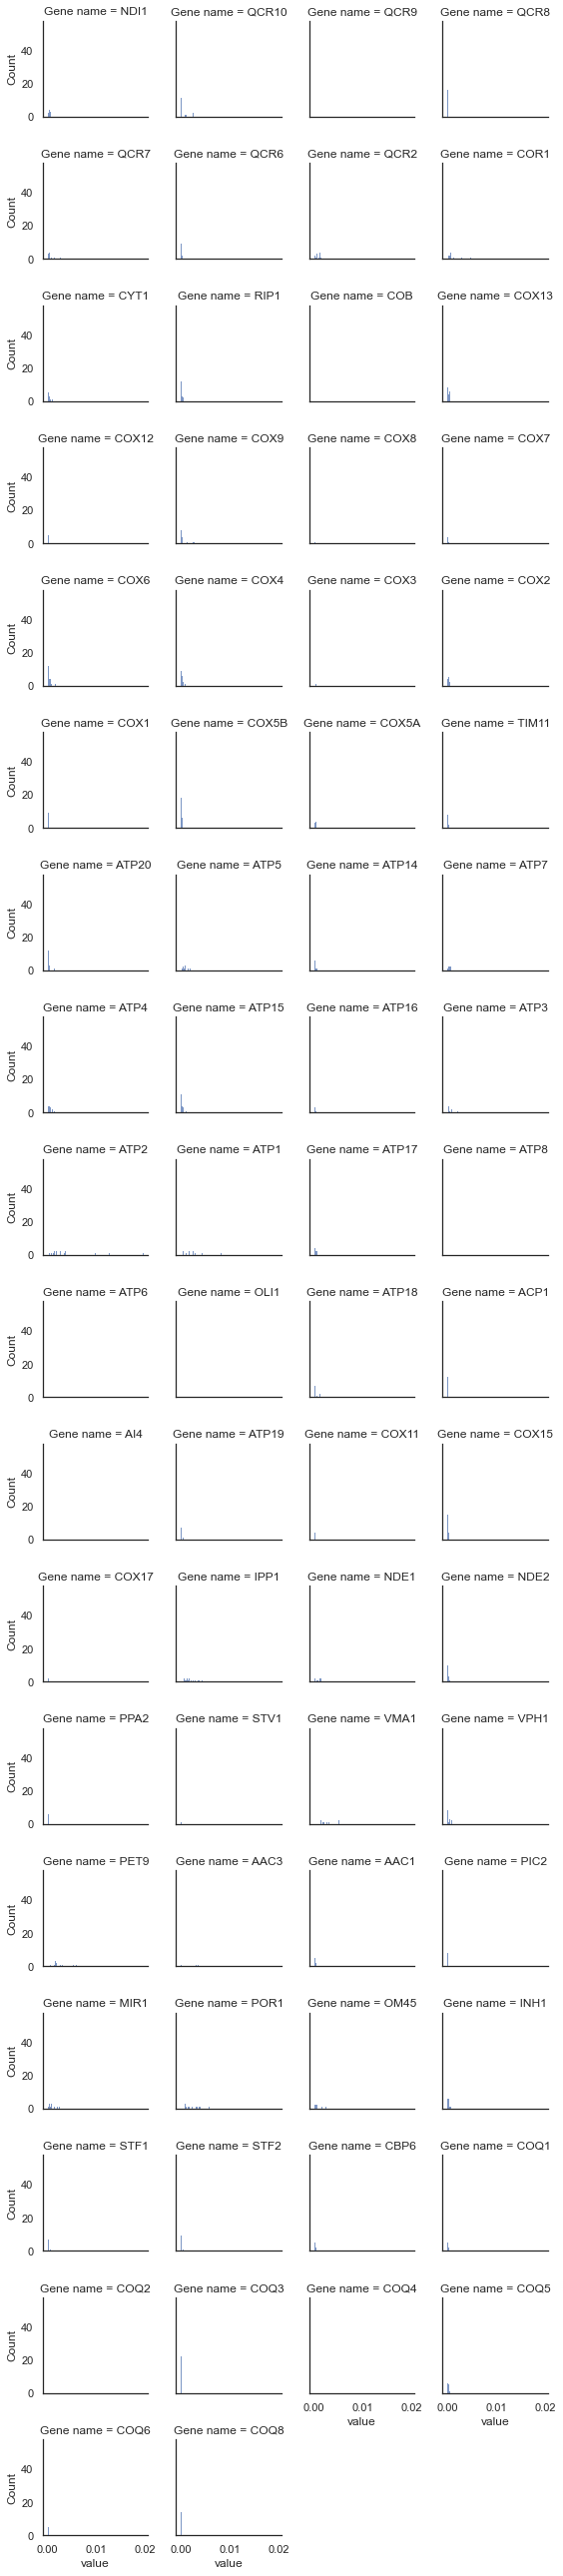

In [9]:
#plot histogram of all proteins in subset list
sns.set_theme(style="white")
sns.displot(
    total_inclusion_etc, x="value", col="Gene name",
    height=2, facet_kws=dict(margin_titles=True),
    col_wrap=4)

In [10]:
#calculate the fraction of 'value' <= 0.00001 for each Gene name
fractions = total_inclusion_etc.groupby('Gene name')['value'].apply(lambda x: (x <= 0.00001).mean())

#create a df from the fractions
df_zero = fractions.reset_index(name='Fraction Zero')

#determine which genes meet the criteria (less than 20 percent 0 occupancy)
geneCorrect = fractions[fractions >= 0.2].index.tolist()
geneTruth = fractions[fractions < 0.2].index.tolist()

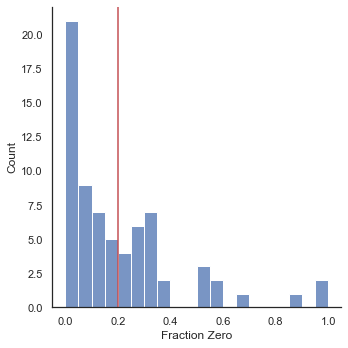

In [11]:
#plot histogram of fraction zeros
sns.set_theme(style="white")
sns.displot(
    df_zero, x="Fraction Zero", bins = 20)
plt.axvline(0.2, color='r')

In [12]:
#filter the dataset for genes in geneTruth
filtered_dataset = total_inclusion_etc[total_inclusion_etc['Gene name'].isin(geneTruth)]

#calculate correction_value as value / MW for each gene within each condition
result = (
    filtered_dataset
    .assign(correction_value=lambda x: x['value'] / x['MW'])
    .groupby(['variable', 'Gene name'])
    .agg(correction_value=('correction_value', 'first'))  #first occurance
    .reset_index()
)

In [13]:
#drop duplicates
ec_number = total_inclusion_etc[['Gene name', 'EC number']].drop_duplicates()

In [14]:
#merge the correction values with EC numbers
result = pd.merge(ec_number, result, on='Gene name', how = 'right')

In [15]:
#calculate the mean correction_value for each combination of 'variable' and 'EC number'
mean_correction_values = (
    result.groupby(['variable', 'EC number'])['correction_value']
    .mean()
    .reset_index(name='mean_correction_value')
)

#merge the mean_correction_values back with the original DataFrame to update the 'correction_value'
df_correction = pd.merge(result, mean_correction_values, on=['variable', 'EC number'])

#update 'correction_value' with the mean values
df_correction['correction_value'] = df_correction['mean_correction_value']

#drop the temporary mean_correction_value column and any duplicates
df_correction.drop(columns=['mean_correction_value'], inplace=True)
df_correction.drop_duplicates(inplace=True)
df_correction = df_correction[['variable', 'correction_value', 'EC number']]

In [16]:
#correct occupancy of genes
genes_to_correct = (
    total_inclusion_etc.loc[total_inclusion_etc['Gene name'].isin(geneCorrect)]
    .merge(df_correction, on=['variable', 'EC number'], how='left')
    .assign(corrected_value=lambda x: x['correction_value'] * x['MW'])
    .drop_duplicates()
)

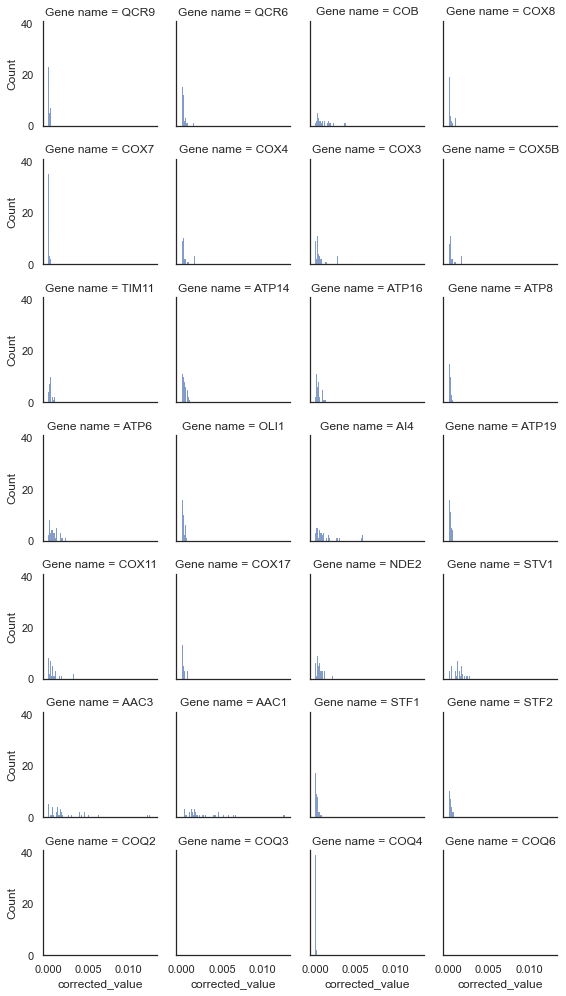

In [17]:
#plot correction results
sns.set_theme(style="white")
sns.displot(genes_to_correct, x="corrected_value", col="Gene name",
    height=2, facet_kws=dict(margin_titles=True),
    col_wrap=4)

In [18]:
#iterate over each row in genes_to_correct to apply corrections
for index, row in genes_to_correct.iterrows():
    orf = row['ORF']
    variable = row['variable']
    corrected_value = row['corrected_value']
    
    #check if the variable (column) exists in yeast_proteomics before assignment
    if variable in yeast_proteomics.columns:
        yeast_proteomics.loc[yeast_proteomics['ORF'] == orf, variable] = corrected_value

#assuming 'Unnamed: 0' is a column that needs to be dropped
if 'Unnamed: 0' in yeast_proteomics.columns:
    yeast_proteomics.drop(columns='Unnamed: 0', inplace=True)

#if ORF is not already set as the index
if yeast_proteomics.index.name != 'ORF':
    yeast_proteomics.set_index('ORF', inplace=True)

#normalize the df to total sum of 1 by dividing each value by the sum of its column
yeast_proteomics = yeast_proteomics.div(yeast_proteomics.sum())

## Pathway Occupancy

### Fermentation

In [19]:
#read in gene inclusion list for fermentation and respiration
yeast_inclusion_ferm = yeast_inclusion.loc[yeast_inclusion['meta_pathway']== 'fermentation']

In [20]:
#merge the proteomics data with the inclusion list 
yeast_proteomics_ferm_inclusion_final = pd.merge(yeast_inclusion_ferm, yeast_proteomics, on = 'ORF', how = 'inner')

In [21]:
#melt df
column_list = list(yeast_proteomics.columns)
yeast_proteomics_ferm_melt = pd.melt(yeast_proteomics_ferm_inclusion_final, id_vars=['ORF'],
                                 value_vars=column_list)

In [22]:
#merge with meta data
yeast_proteomics_ferm_melt = pd.merge(yeast_proteomics_ferm_melt, 
                                      yeast_meta[['variable', 'author', 'quant', 'media', 'growth_rate', 'carbon_source', 'carbon_source_cat', 'method']].drop_duplicates(), 
                                      on='variable', how='left')

In [23]:
#use only the fermentable carbon sources from batch culture for fermentation specific activity
yeast_proteomics_ferm_melt_sa = yeast_proteomics_ferm_melt.loc[ (yeast_proteomics_ferm_melt['carbon_source_cat'] == 'fermentable') 
                               & (yeast_proteomics_ferm_melt['method'] == 'batch')]

In [24]:
#only use datasets that quantify using mass spec
yeast_proteomics_ferm_melt_sa = yeast_proteomics_ferm_melt_sa.loc[yeast_proteomics_ferm_melt_sa['quant'] == 'mass_spec']

In [25]:
#remove papers that do not fit quant or extraction the criteria
additional_drop = np.array(['LAW', 'Lu', 'DGD', 'NAG', 'LU', 'LEE2', 'PIC'])

In [26]:
#drop above datasets
for author in additional_drop:
    yeast_proteomics_ferm_melt_sa = yeast_proteomics_ferm_melt_sa.loc[~(yeast_proteomics_ferm_melt_sa['variable'].str.contains(author))]

In [27]:
#make a copy that will not get biomass corrected for comparision
yeast_proteomics_ferm_no_biomass_correction = yeast_proteomics_ferm_melt_sa.copy()

### Biomass Correction

In [28]:
#read in the fraction to biomass spreadsheet
yeast_biomass = pd.read_csv('./data/2022_11_03_yeast_biomass.csv')

In [29]:
#fraction of carbon dedicated to producing biomass
yeast_biomass_ferm_mean = yeast_biomass.loc[yeast_biomass['Condition'] == 'Fermentation']['Fraction '].mean()

In [30]:
#merge with inclusion list
yeast_proteomics_ferm_melt_sa = pd.merge(yeast_proteomics_ferm_melt_sa, yeast_inclusion[['pathway', 'Gene name', 'ORF']], how='left', on='ORF')

In [31]:
#biomass correction applies to only the enzymes in glycolysis
yeast_proteomics_ferm_melt_sa.loc[((yeast_proteomics_ferm_melt_sa['media'] == 'minimal') & 
                                  (yeast_proteomics_ferm_melt_sa['pathway'] == 'glycolysis')), 
                                  'value'] = yeast_proteomics_ferm_melt_sa['value'] * (1-yeast_biomass_ferm_mean)

#### Fermentation

In [32]:
#groupby dataset variable and sum the entire set of genes for final sum
yeast_proteomics_ferm_melt_sa.drop_duplicates(inplace = True)
yeast_proteomics_ferm_inclusion_final_gene_sum = yeast_proteomics_ferm_melt_sa.groupby('variable').sum()
yeast_proteomics_ferm_inclusion_final_gene_sum.reset_index(inplace= True)
yeast_proteomics_ferm_inclusion_final_gene_sum['estimate'] = 'fermentation'
yeast_proteomics_ferm_inclusion_final_gene_sum['organism'] = 'yeast'

In [33]:
#mean occupancy
yeast_proteomics_ferm_inclusion_final_gene_sum.mean()

value    0.091283
dtype: float64

In [34]:
#save df
yeast_proteomics_ferm_inclusion_final_gene_sum.to_csv('./data/2024_02_25_yeast_specific_activity_fermentation.csv')

In [35]:
#calculate occupancy for df that was not biomass corrected
yeast_proteomics_ferm_no_biomass_correction.drop_duplicates(inplace = True)
yeast_proteomics_ferm_inclusion_final_gene_sum_no_correction = yeast_proteomics_ferm_no_biomass_correction.groupby('variable').sum()
yeast_proteomics_ferm_inclusion_final_gene_sum_no_correction.reset_index(inplace= True)
yeast_proteomics_ferm_inclusion_final_gene_sum_no_correction['estimate'] = 'fermentation'
yeast_proteomics_ferm_inclusion_final_gene_sum_no_correction['organism'] = 'yeast'

In [36]:
#mean occupancy
yeast_proteomics_ferm_inclusion_final_gene_sum_no_correction.mean()

value    0.093893
dtype: float64

In [37]:
#calculate mean values
mean_initial = yeast_proteomics_ferm_inclusion_final_gene_sum_no_correction['value'].mean()
mean_final = yeast_proteomics_ferm_inclusion_final_gene_sum['value'].mean()

#calculate percent decrease
percent_decrease = (mean_initial - mean_final) / mean_initial * 100

#create the message string
message = "Percent decrease = {:.2f}%".format(percent_decrease)
message

'Percent decrease = 2.78%'

### Respiration

#### Full mitochondria list

In [38]:
#load data
gene_orf = pd.read_csv('./data/gene_orfs.csv', header=None, names=['ORF', 'Gene name'])
bartolomeo_2020 = pd.read_csv('./data/bartolomeo_2020.csv')

#filter for non-null Gene ontology (cellular component) and contains 'mito'
bartolomeo_2020_mito = bartolomeo_2020.dropna(subset=['Gene ontology (cellular component)'])
bartolomeo_2020_mito = bartolomeo_2020_mito[bartolomeo_2020_mito['Gene ontology (cellular component)'].str.contains('mito') & bartolomeo_2020_mito['Gene name'].notnull()]

# Merge with gene_orf to get ORF values
bartolomeo_2020_mito = bartolomeo_2020_mito.merge(gene_orf, on='Gene name', how='left')

# Select only 'ORF' and 'Gene name' columns
mito_list = bartolomeo_2020_mito[['ORF', 'Gene name']]

In [39]:
#convert the 'ORF' column of 'yeast_inclusion_ferm' to a set for faster lookup
ferm_set = set(yeast_inclusion_ferm['ORF'])

#use boolean indexing to filter out rows in 'mito_list' where 'ORF' values are in 'ferm_set'
mito_list = mito_list[~mito_list['ORF'].isin(ferm_set)]

In [40]:
#mito list to csv
mito_list.to_csv('./data/yeast_full_mito_list.csv')

In [41]:
#merge mito list with proteomics df
resp_proteomics_full_mito = pd.merge(mito_list, yeast_proteomics, on = 'ORF', how = 'left')

In [42]:
#merge 
resp_proteomics_full_mito = pd.merge(resp_proteomics_full_mito, yeast_inclusion[['ORF', 'pathway']], on='ORF', how='left')

In [43]:
resp_proteomics_full_mito_melt = pd.melt(resp_proteomics_full_mito, id_vars=['ORF', 'pathway'],
                                 value_vars=column_list)

In [44]:
resp_proteomics_full_mito_melt = pd.merge(resp_proteomics_full_mito_melt, yeast_meta, on='variable', how='left')

#### Partial correlated list

In [45]:
#define columns to drop in advance (this part remains the same)
yeast_columns_to_drop = ['pathway', 'meta_pathway', 'ORF', 'protein category', 'MW', 'EC number']

#combine filtering and merging into one line
yeast_proteomics_resp = pd.merge(yeast_inclusion[yeast_inclusion['meta_pathway'] == 'respiration'], yeast_proteomics, on='ORF', how='inner')

In [46]:
#calculate pearson correlation of mito proteins with core genes
def geneCoexpression(proteomics_dataset, core_list, merger, columns_to_drop):
    
    core_list = core_list.drop(columns = columns_to_drop)
    core_list = core_list.set_index('Gene name')
    core_list_t = core_list.transpose()
    core_list_t["Core_Sum"] = core_list_t.sum(axis=1)
    core_list_t = core_list_t[["Core_Sum"]]
    core_list_sum = core_list_t.transpose()
    core_list_sum.reset_index(inplace = True)
    core_list_sum = core_list_sum.set_index('Gene name')
    proteomics_dataset = proteomics_dataset.set_index('ORF')
    yeast_proteomics_with_core = pd.concat([core_list_sum, proteomics_dataset])
    yeast_proteomics_with_core_t = yeast_proteomics_with_core.transpose()
    column_list = yeast_proteomics_with_core_t.columns
    yeast_proteomics_with_core_t = yeast_proteomics_with_core_t.loc[:,~yeast_proteomics_with_core_t.columns.duplicated()]
    
    gene_name = []
    r_value = []
    p_value = []

    #Calculates the Pearson correlation and p value for each gene with the core sum 
    for gene in column_list: 

        x = yeast_proteomics_with_core_t['Core_Sum'].values
        y = yeast_proteomics_with_core_t[gene].values
        
        #print(x)

        bad = ~np.logical_or(np.isnan(x), np.isnan(y))

        test1 = np.compress(bad, x)  
        test2 = np.compress(bad, y)  

        #pearson correlation
        r, p = scipy.stats.pearsonr(test1, test2)
        #print(p)
        #print(r)
    
        gene_name.append(gene)
        r_value.append(r)
        p_value.append(p)
    
    d = {'ORF': gene_name, 'R value': r_value, 'P value': p_value}
    df = pd.DataFrame(data=d)
    
    df = df.sort_values('P value')
    df = df.reset_index(drop = True)
    
    #bonferroni correction
    df['Bon'] = df['P value'] * len(df) 
    #benjamini hochberg correction
    df['BH'] = df['P value'] * len(df) / (df.index + 1)
    
    
    return(df)

In [47]:
#renaming the df
proteomics_dataset_temp = yeast_proteomics.copy().reset_index()

In [48]:
#running function 
yeast_mito_geneCoexpress = geneCoexpression(proteomics_dataset_temp, yeast_proteomics_resp, "ORF", yeast_columns_to_drop)

In [49]:
#function output to csv
yeast_mito_geneCoexpress.to_csv('./data/yeast_mito_geneCoexpress.csv')

In [50]:
yeast_inclusion_resp = yeast_inclusion.loc[yeast_inclusion['meta_pathway'] == 'respiration']

#merge 'mito_list' and 'test' dataframes and immediately filter rows based on conditions
df_mito_sig = pd.merge(mito_list, yeast_mito_geneCoexpress, on='ORF', how='inner') \
                .query('`R value` >= 0 and `BH` < 0.05')

#assuming yeast_inclusion_resp is already prepared and doesn't require the dropped columns
df_resp = yeast_inclusion_resp.copy()

resp_selected_columns = df_resp[['ORF', 'Gene name']]
mito_sig_selected_columns = df_mito_sig[['ORF', 'Gene name']]

#concat the filtered mito dataframe with the resp dataframe and remove duplicates
partial_mito_inclusion_list = pd.concat([resp_selected_columns, mito_sig_selected_columns]).drop_duplicates()

In [51]:
#merge partial list with proteomics df
resp_proteomics_partial_mito = pd.merge(partial_mito_inclusion_list, yeast_proteomics, on = 'ORF', how = 'left')

In [52]:
#merge partial list with inclusion
resp_proteomics_partial_mito = pd.merge(resp_proteomics_partial_mito, yeast_inclusion[['ORF', 'pathway']], on='ORF', how='left')

In [53]:
#melt df
resp_proteomics_partial_mito_melt = pd.melt(resp_proteomics_partial_mito, id_vars=['ORF', 'pathway'],
                                 value_vars=column_list)

In [54]:
#merge with meta data
resp_proteomics_partial_mito_melt = pd.merge(resp_proteomics_partial_mito_melt, yeast_meta, on='variable', how='left')

#### Core Respiration list

In [55]:
#melt df
resp_proteomics_core_melt = pd.melt(yeast_proteomics_resp, id_vars=['ORF', 'pathway'],
                                 value_vars=column_list)

In [56]:
#merge with meta data
resp_proteomics_core_melt = pd.merge(resp_proteomics_core_melt, yeast_meta, on='variable', how='left')

In [57]:
#make copy of df without biomass correction
resp_proteomics_core_melt_no_biomass_correction = resp_proteomics_core_melt.copy()

### Biomass Correction

In [58]:
#read in the fraction to biomass data
yeast_biomass = pd.read_csv('./data/2022_11_03_yeast_biomass.csv')

In [59]:
#fraction of carbon dedicated to producing biomass
yeast_biomass_resp_mean = yeast_biomass.loc[yeast_biomass['Condition'] == 'Respiration']['Fraction '].mean()

In [60]:
#list of the three dfs
datasets = [resp_proteomics_core_melt, resp_proteomics_partial_mito_melt, resp_proteomics_full_mito_melt]

In [61]:
#biomass correction for all three dfs

#biomass correction only for tca enzymes
condition = (lambda df: (df['media'] == 'minimal') & (df['pathway'] == 'tca'))
operation = (lambda df: df.loc[condition(df), 'value'] * (1 - yeast_biomass_resp_mean))

#iterate over each DataFrame and apply the operation
for dataset in datasets:
    dataset.loc[condition(dataset), 'value'] = operation(dataset)

#### Full mito quant

In [62]:
#use only the nonfermentable carbon sources from batch culture for fermentation specific activity
resp_proteomics_full_mito_sa = resp_proteomics_full_mito_melt.loc[ (resp_proteomics_full_mito_melt['carbon_source_cat'] == 'nonfermentable') 
                               & (resp_proteomics_full_mito_melt['method'] == 'batch')]

In [63]:
#drop duplicates
resp_proteomics_full_mito_sa = resp_proteomics_full_mito_sa.drop_duplicates()

In [64]:
#groupby dataset variable and sum the entire set of genes
resp_proteomics_full_mito_sa_sum = resp_proteomics_full_mito_sa.groupby('variable').sum().reset_index().assign(estimate = 'respiration', organism = 'yeast')


In [65]:
#mean occupancy
resp_proteomics_full_mito_sa_sum['value'].mean()

0.2166295200132669

In [66]:
#df to csv
resp_proteomics_full_mito_sa_sum.to_csv('./data/2024_02_25_yeast_specific_activity_resp_full_mito.csv')

#### Partial mito quant

In [67]:
#use only the nonfermentable carbon sources from batch culture for fermentation specific activity
resp_proteomics_partial_mito_sa = resp_proteomics_partial_mito_melt.loc[ (resp_proteomics_partial_mito_melt['carbon_source_cat'] == 'nonfermentable') 
                               & (resp_proteomics_partial_mito_melt['method'] == 'batch')]

In [68]:
#drop duplicates
resp_proteomics_partial_mito_sa = resp_proteomics_partial_mito_sa.drop_duplicates()

In [69]:
#groupby dataset variable and sum the entire set of genes
resp_proteomics_partial_mito_sa_sum = resp_proteomics_partial_mito_sa.groupby('variable').sum().reset_index().assign(estimate = 'respiration', organism = 'yeast')


In [70]:
#mean occupancy
resp_proteomics_partial_mito_sa_sum['value'].mean()

0.1490351620636183

In [71]:
#df to csv
resp_proteomics_partial_mito_sa_sum.to_csv('./data/2024_02_25_yeast_specific_activity_resp_partial_mito.csv')

#### Core mito quant

In [72]:
#use only the nonfermentable carbon sources from batch culture for fermentation specific activity
resp_proteomics_core_melt_sa = resp_proteomics_core_melt.loc[ (resp_proteomics_core_melt['carbon_source_cat'] == 'nonfermentable') 
                               & (resp_proteomics_core_melt['method'] == 'batch')]

In [73]:
#drop duplicates
resp_proteomics_core_melt_sa = resp_proteomics_core_melt_sa.drop_duplicates()

In [74]:
#groupby dataset variable and sum the entire set of genes
resp_proteomics_core_melt_sa_sum = resp_proteomics_core_melt_sa.groupby('variable').sum().reset_index().assign(estimate = 'respiration', organism = 'yeast')


In [75]:
#mean occupancy
resp_proteomics_core_melt_sa_sum['value'].mean()

0.11676296447919755

In [76]:
#df to csv
resp_proteomics_core_melt_sa_sum.to_csv('./data/2024_02_25_yeast_specific_activity_resp_core.csv')

In [77]:
#uncorrected biomass data
#use only the nonfermentable carbon sources from batch culture for fermentation specific activity
resp_proteomics_core_melt_no_biomass_correction_sa = resp_proteomics_core_melt_no_biomass_correction.loc[ (resp_proteomics_core_melt_no_biomass_correction['carbon_source_cat'] == 'nonfermentable') 
                               & (resp_proteomics_core_melt_no_biomass_correction['method'] == 'batch')]

In [78]:
#drop duplicates
resp_proteomics_core_melt_no_biomass_correction_sa = resp_proteomics_core_melt_no_biomass_correction_sa.drop_duplicates()

In [79]:
#groupby dataset variable and sum the entire set of genes
resp_proteomics_core_melt_no_biomass_sum = resp_proteomics_core_melt_no_biomass_correction_sa.groupby('variable').sum().reset_index().assign(estimate = 'respiration', organism = 'yeast')


In [80]:
#mean occupancy
resp_proteomics_core_melt_no_biomass_sum['value'].mean()

0.11916916883498596

In [81]:
#calculate mean values
mean_initial = resp_proteomics_core_melt_no_biomass_sum['value'].mean()
mean_final = resp_proteomics_core_melt_sa_sum['value'].mean()

#calculate percent decrease
percent_decrease = (mean_initial - mean_final) / mean_initial * 100

#print percent decrease
message = "Percent decrease = {:.2f}%".format(percent_decrease)
message

'Percent decrease = 2.02%'

### ATP-producing space

#### Ferm space

In [82]:
#filter out datasets that do not meet the criteria
yeast_proteomics_ferm_melt_atp_space = yeast_proteomics_ferm_melt.loc[yeast_proteomics_ferm_melt['quant'] == 'mass_spec']

yeast_proteomics_ferm_melt_atp_space = yeast_proteomics_ferm_melt_atp_space[~yeast_proteomics_ferm_melt_atp_space['variable'].isin(['Lu_2007_minimal_1', 'ho_2018_LU_1', 'Lu_2007_rich_1'])]

In [83]:
#merge with inclusion list
yeast_proteomics_ferm_melt_atp_space = pd.merge(yeast_proteomics_ferm_melt_atp_space, yeast_inclusion[['ORF', 'pathway']], on='ORF', how='left')

In [84]:
#biomass correction 
yeast_proteomics_ferm_melt_atp_space.loc[((yeast_proteomics_ferm_melt_atp_space['media'] == 'minimal') & 
                                  (yeast_proteomics_ferm_melt_atp_space['pathway'] == 'glycolysis')), 
                                  'value'] = yeast_proteomics_ferm_melt_atp_space['value'] * (1-yeast_biomass_ferm_mean)

In [85]:
#drop duplicates
yeast_proteomics_ferm_melt_atp_space.drop_duplicates(inplace = True)

In [86]:
#groupby dataset variable and sum the entire set of genes
yeast_proteomics_ferm_atp_space_sum = yeast_proteomics_ferm_melt_atp_space.groupby('variable').sum().reset_index().assign(estimate = 'ferm', organism = 'yeast')


In [87]:
#mean occupancy
yeast_proteomics_ferm_atp_space_sum['value'].mean()

0.10253128643135465

#### Respiration

In [88]:
#list of datasets
datasets = [
    resp_proteomics_core_melt,
    resp_proteomics_partial_mito_melt,
    resp_proteomics_full_mito_melt]

#specified condition and operation
condition = lambda df: (df['media'] == 'minimal') & (df['pathway'] == 'tca')
operation = lambda df: df['value'] * (1 - yeast_biomass_resp_mean)

#list to hold the processed datasets
processed_datasets = []

#drops datasets that do not meet the criteria
for dataset in datasets:
    # Drop datasets that are not mass spec or do not meet the extraction criteria
    filtered_dataset = dataset.loc[dataset['quant'] == 'mass_spec']
    filtered_dataset = filtered_dataset[~filtered_dataset['variable'].isin(['Lu_2007_minimal_1', 'ho_2018_LU_1', 'Lu_2007_rich_1'])]
    filtered_dataset = filtered_dataset.drop_duplicates()
    #filtered_dataset = pd.merge(filtered_dataset, yeast_inclusion[['ORF', 'pathway']], on='ORF', how='left')
    #print(filtered_dataset)
    
    #apply the condition and operation for adjusting for biomass
    filtered_dataset.loc[condition(filtered_dataset), 'value'] = operation(filtered_dataset)
    
    #append the processed dataset to the list
    processed_datasets.append(filtered_dataset)

#replacing the processed datasets back to their respective variables
resp_proteomics_core_mito_melt_atp_space, resp_proteomics_partial_mito_melt_atp_space,resp_proteomics_full_mito_melt_atp_space  = processed_datasets

#### ATP-producing occupancy sum

#### Core

In [89]:
#append ferm and resp
atp_space_core = yeast_proteomics_ferm_melt_atp_space.append(resp_proteomics_core_mito_melt_atp_space, ignore_index=True)

In [90]:
#groupby dataset variable and sum the entire set of genes
atp_space_core_sum = atp_space_core.groupby('variable').sum().reset_index().assign(estimate = 'total', organism = 'yeast')

In [91]:
#mean occupancy
atp_space_core_sum['value'].mean()

0.16757971719697087

In [92]:
#save df to csv
atp_space_core_sum.to_csv('./data/2024_02_25_yeast_atp_total_core.csv')

#### Partial

In [93]:
#append ferm and resp
atp_space_partial = yeast_proteomics_ferm_melt_atp_space.append(resp_proteomics_partial_mito_melt_atp_space, ignore_index=True)

In [94]:
#groupby dataset variable and sum the entire set of genes
atp_space_partial_sum = atp_space_partial.groupby('variable').sum().reset_index().assign(estimate = 'total', organism = 'yeast')

In [95]:
#mean occupancy
atp_space_partial_sum['value'].mean()

0.188555312319481

In [96]:
#save df to csv
atp_space_partial_sum.to_csv('./data/2024_02_25_yeast_atp_total_partial_mito.csv')

#### Mito

In [97]:
#append ferm and resp
atp_space_full = yeast_proteomics_ferm_melt_atp_space.append(resp_proteomics_full_mito_melt_atp_space, ignore_index=True)

In [98]:
#groupby dataset variable and sum the entire set of genes
atp_space_full_sum = atp_space_full.groupby('variable').sum().reset_index().assign(estimate = 'total', organism = 'yeast')

In [99]:
#mean occupancy
atp_space_full_sum['value'].mean()

0.2587029120622031

In [100]:
#save df to csv
atp_space_full_sum.to_csv('./data/2024_02_25_yeast_atp_total_full_mito.csv')

### Elsemann Data

In [102]:
#read in elesemann data
elsemann_2022 = pd.read_excel('./data/2023_10_31_elsemann_2022_proteomics.xlsx')

## *S. cerevisiae* translation 

In [103]:
#path to excel
file_path = './data/2023_10_31_elsemann_2022_proteomics.xlsx'

#read all sheet (the result is a dictionary where each key is a sheet name)
#and each value is a df containing the data from that sheet
all_sheets_dict = pd.read_excel(file_path, sheet_name=None)

In [104]:
for sheet_name, df in all_sheets_dict.items():
    #melt the df with 'Majority protein IDs' as id_vars
    melted_df = pd.melt(df, id_vars=['Majority protein IDs'], var_name='Variable', value_name='Value')
    
    melted_df['Value'] = melted_df['Value'].fillna(0)
    
    #update the dictionary with the melted df
    all_sheets_dict[sheet_name] = melted_df

In [105]:
#initialize an empty list to store each modified DataFrame
df_list = []

#iterate through each sheet name and DataFrame in the dictionary
for condition, df in all_sheets_dict.items():
    #add a new column 'condition' to the df
    df['Condition'] = condition
    
    #append the modified df to the list
    df_list.append(df)

#concat all dfs into one
combined_df = pd.concat(df_list, ignore_index=True)

In [106]:
combined_df[['Substrate', 'Growth_Rate']] = combined_df['Condition'].str.split('_', n=1, expand=True)

In [107]:
df1 = pd.DataFrame(combined_df)
df2 = pd.DataFrame(gene_orf)

# Create a mapping from ORFs to gene names
orf_to_gene_map = df2.set_index('ORF')['Gene name'].to_dict()

# Function to extract and map ORF to gene name
def map_orf_to_gene(majority_protein_id):
    for orf in orf_to_gene_map.keys():
        if orf in majority_protein_id:
            return orf  # Return ORF if found
    return None  # Return None if no ORF found

# Vectorized application of the mapping function
df1['ORF'] = df1['Majority protein IDs'].apply(map_orf_to_gene)

In [108]:
#merge df1 with df_gene_info on the 'ORF' column
elsemann_atp_total = pd.merge(yeast_inclusion, df1, on='ORF', how='left')

In [109]:
#drop duplicates
elsemann_atp_total.drop_duplicates(inplace = True)

In [110]:
#groupby dataset variable and sum the entire set of genes
elsemann_atp_total_sum = elsemann_atp_total.groupby('Variable').sum().reset_index()

In [111]:
#split string to obtain growth rate and repicates number
elsemann_atp_total_sum[['condition', 'growth_rate', 'rep']] = elsemann_atp_total_sum['Variable'].str.extract(r'([^_]+)_([0-9.]+)_([0-9]+)')

In [112]:
#growth rate to numeric
elsemann_atp_total_sum['growth_rate'] = pd.to_numeric(elsemann_atp_total_sum['growth_rate'], errors='coerce')

In [113]:
#expport atp sum to csv
elsemann_atp_total_sum.to_csv('./data/elsemann_atp_total_sum.csv')

In [114]:
#subset condition
elsemann_atp_total_glucose = elsemann_atp_total_sum.loc[elsemann_atp_total_sum['condition'] == 'glucose']

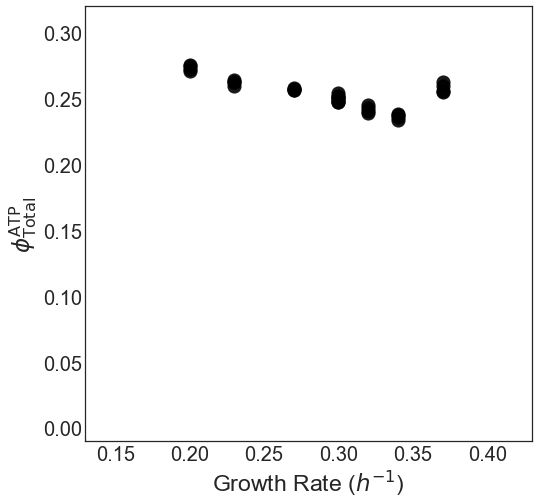

In [115]:
#plot atp-producing occupancy vs. growth rate
fig, ax = plt.subplots(figsize=(8,8))
ax.patch.set_facecolor('white')
sns.set_context("talk")

sns.scatterplot(elsemann_atp_total_glucose['growth_rate']/100, elsemann_atp_total_glucose['Value'], color = 'black', alpha=.9, linewidth = 0, s=200, zorder = 3)

ax.set_ylim(-0.01, 0.32)
ax.set_xlim(.13, 0.43)

#axis format
ax.set_xlabel("Growth Rate " + r'($h^{-1}$)', fontsize=23)
ax.set_ylabel(r"$\phi_{\mathrm{Total}}^{\mathrm{ATP}}$", fontsize=23)
ax.tick_params(axis='both', which='major', labelsize=20, length=0)

#save figure
fig.savefig('./Figures/yeast_total_atp_growth.svg',format='svg', dpi=1200)

In [116]:
#read in translation inclusion list
yeast_translation_inclusion = pd.read_csv('./data/2024_01_27_scerevisiae_translation.csv')

In [117]:
#rename columns
yeast_translation_inclusion.rename(columns = {'	Gene/Complex': 'Gene name', 'Systematic Name/Complex Accession': 'ORF'}, inplace = True)

In [118]:
#merge df1 with df_gene_info on the 'ORF' column
elsemann_translation = pd.merge(yeast_translation_inclusion, df1, on='ORF', how='left')

In [119]:
#groupby dataset variable and sum the entire set of genes
elsemann_translation_sum = elsemann_translation.groupby('Variable').sum().reset_index()

In [120]:
#split string to obtain growth rate and repicates number
elsemann_translation_sum[['condition', 'growth_rate', 'rep']] = elsemann_translation_sum['Variable'].str.extract(r'([^_]+)_([0-9.]+)_([0-9]+)')

In [121]:
#growth rate to numeric
elsemann_translation_sum['growth_rate'] = pd.to_numeric(elsemann_translation_sum['growth_rate'], errors='coerce')

In [122]:
#subset condition
elsemann_translation_glucose = elsemann_translation_sum.loc[elsemann_translation_sum['condition'] == 'glucose']

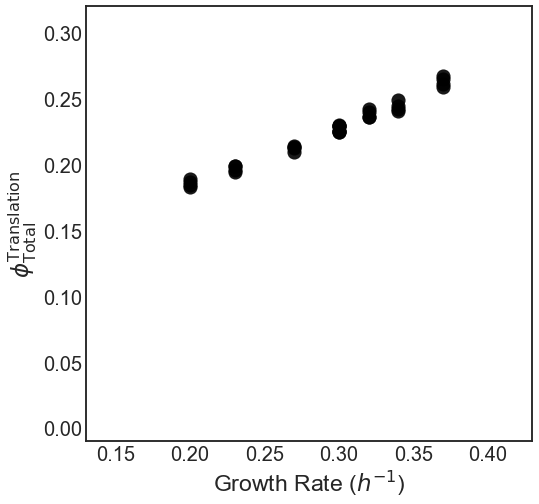

In [123]:
#plot translation occupancy vs. growth rate
fig, ax = plt.subplots(figsize=(8,8))
ax.patch.set_facecolor('white')
sns.set_context("talk")

sns.scatterplot(elsemann_translation_glucose['growth_rate']/100, elsemann_translation_glucose['Value'], color = 'black', alpha=.9, linewidth = 0, s=200, zorder = 3)

ax.set_ylim(-0.01, 0.32)
ax.set_xlim(.13, 0.43)

#axis format
ax.set_xlabel("Growth Rate " + r'($h^{-1}$)', fontsize=23)
ax.set_ylabel(r"$\phi_{\mathrm{Total}}^{\mathrm{Translation}}$", fontsize=23)
ax.tick_params(axis='both', which='major', labelsize=20, length=0)

#save figure
fig.savefig('./Figures/yeast_total_translation_growth.svg',format='svg', dpi=1200)